In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

2023-10-22 17:53:11.598724: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 17:53:11.598845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 17:53:11.598938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 17:53:11.698924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3*1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-22 17:53:16.203669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 17:53:16.244211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 17:53:16.244269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 17:53:16.247661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 17:53:16.247718: I tensorflow/compile

In [3]:
train_images_path ="./images/train/"
test_images_path ="./images/validation/"

In [4]:
labels = ["angry","disgust","fear","happy","neutral","sad","surprise"]

In [5]:
# this function is used to load images from the folder
# it returns a list of images and a list of labels
# the images are loaded in the order of the labels
# the labels are the subfolder names
# the function works recursively
def loadImages(folderPath):
    images = []
    directories = set()
    labels = []
    for file in os.listdir(folderPath):
        if os.path.isdir(os.path.join(folderPath,file)):
            directories.add(file)
        else:
            label = os.path.basename(folderPath)
            labels.append(label)
            if file.endswith('jpg') == False:
                continue
            img = plt.imread(os.path.join(folderPath,file))
            if img is not None:
                images.append(img)
                
    for dir in directories:
        retImages,retLabels =  loadImages(os.path.join(folderPath,dir))
        if retImages is not None and len(retImages) > 0:
            images += retImages
            labels += retLabels
    
    print("Loaded ",len(images)," images from ",folderPath)
    return images, labels

In [6]:
train_images,train_labels = loadImages(train_images_path)
test_images,test_labels = loadImages(test_images_path)

Loaded  4982  images from  ./images/train/neutral
Loaded  436  images from  ./images/train/disgust
Loaded  4938  images from  ./images/train/sad
Loaded  3205  images from  ./images/train/surprise
Loaded  4103  images from  ./images/train/fear
Loaded  3993  images from  ./images/train/angry
Loaded  7164  images from  ./images/train/happy
Loaded  28821  images from  ./images/train/
Loaded  1216  images from  ./images/validation/neutral
Loaded  111  images from  ./images/validation/disgust
Loaded  1139  images from  ./images/validation/sad
Loaded  797  images from  ./images/validation/surprise
Loaded  1018  images from  ./images/validation/fear
Loaded  960  images from  ./images/validation/angry
Loaded  1825  images from  ./images/validation/happy
Loaded  7066  images from  ./images/validation/


In [7]:
print("Number of train images loaded: ",len(train_images))
print("Number of train labels loaded: ",len(train_labels))
print("Number of test images loaded: ",len(test_images))
print("Number of test labels loaded: ",len(test_labels))

Number of train images loaded:  28821
Number of train labels loaded:  28821
Number of test images loaded:  7066
Number of test labels loaded:  7066


In [8]:
# This function gets the indexs of the images that belong to the labels
# it returns a list of lists, each list contains the index ranges of the images that belong to the label
def getLabelRanges(labelData,labels):
    labelRanges = []
    for label in labels:
        labelRanges.append([i for i, x in enumerate(labelData) if x == label])
    return labelRanges
    

In [9]:
label_ranges_train = getLabelRanges(train_labels,labels)
label_ranges_test = getLabelRanges(test_labels,labels)

per_label_range_train = []
for sets in label_ranges_train:
    per_label_range_train.append((min(sets),max(sets),train_labels[sets[0]],len(sets)))
    
per_label_range_train

[(17664, 21656, 'angry', 3993),
 (4982, 5417, 'disgust', 436),
 (13561, 17663, 'fear', 4103),
 (21657, 28820, 'happy', 7164),
 (0, 4981, 'neutral', 4982),
 (5418, 10355, 'sad', 4938),
 (10356, 13560, 'surprise', 3205)]

# Train Class Distribution Plotting

<BarContainer object of 7 artists>

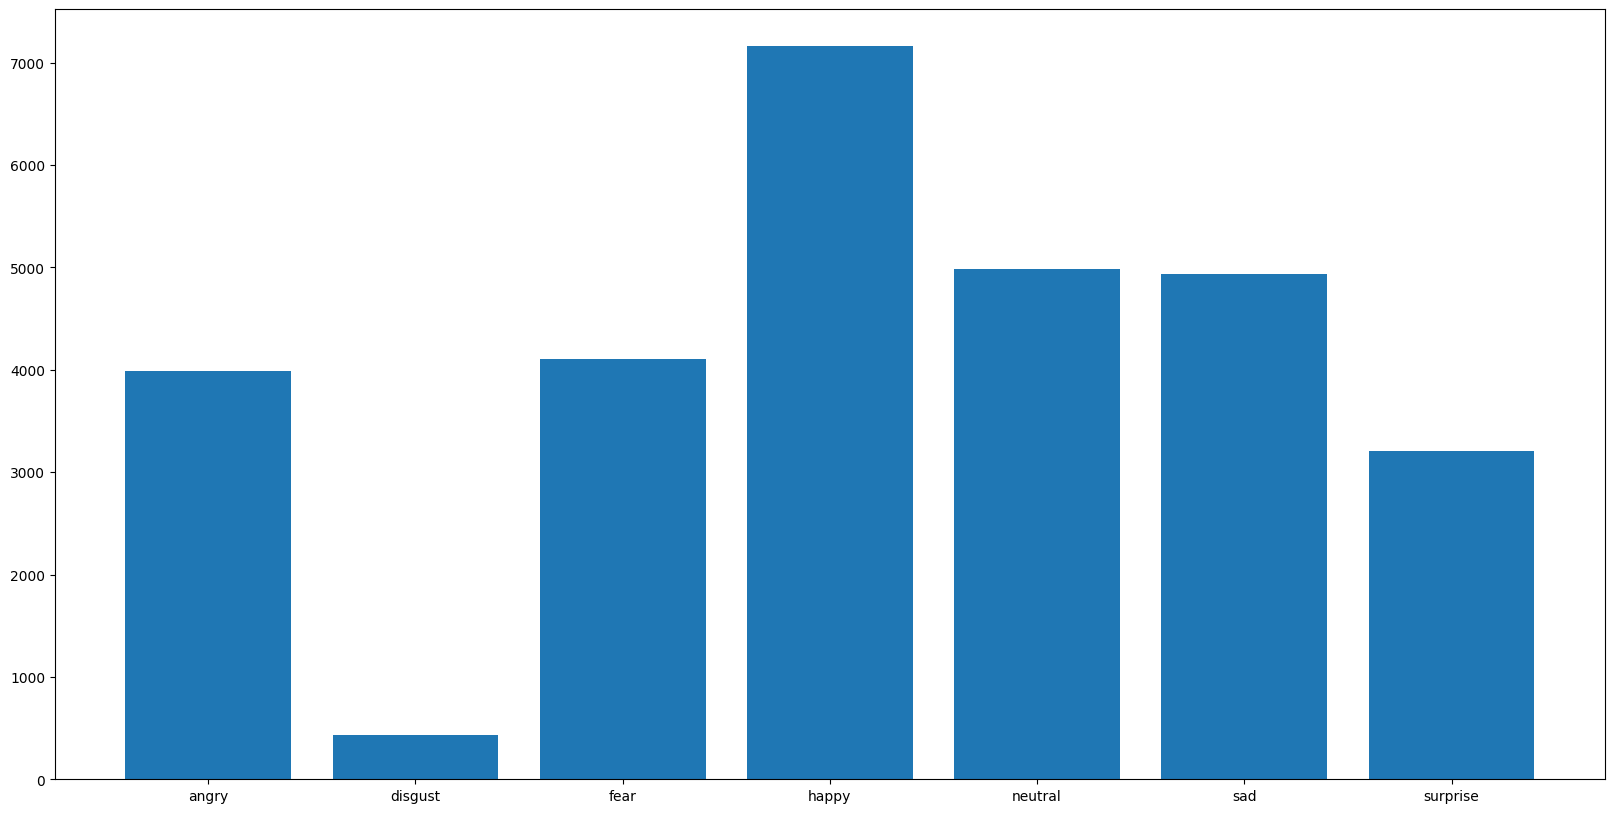

In [10]:
# Show class distribution
plt.figure(figsize=(20,10))
plt.bar(labels, [len(sets) for sets in label_ranges_train])

# Train Random Images per Label

In [11]:
# display 4 random images for each label
# the images are displayed in the order of the labels
# uses the per_label_range_train variable which was calculated earlier
def displayRandomImages(train_images):
    global labels, per_label_range_train
    # plt.style.use('dark_background')
    fig, ax = plt.subplots(len(labels), 4, figsize=(10,10))
    fig.tight_layout()
    for i in range(7):
        l = random.sample(range(per_label_range_train[i][0],per_label_range_train[i][1]),4)
        for j in range(4):
            ax[i][j].imshow(train_images[l[j]])
            ax[i][j].set_title(train_labels[l[j]])
            ax[i][j].axis('off')
    plt.show()

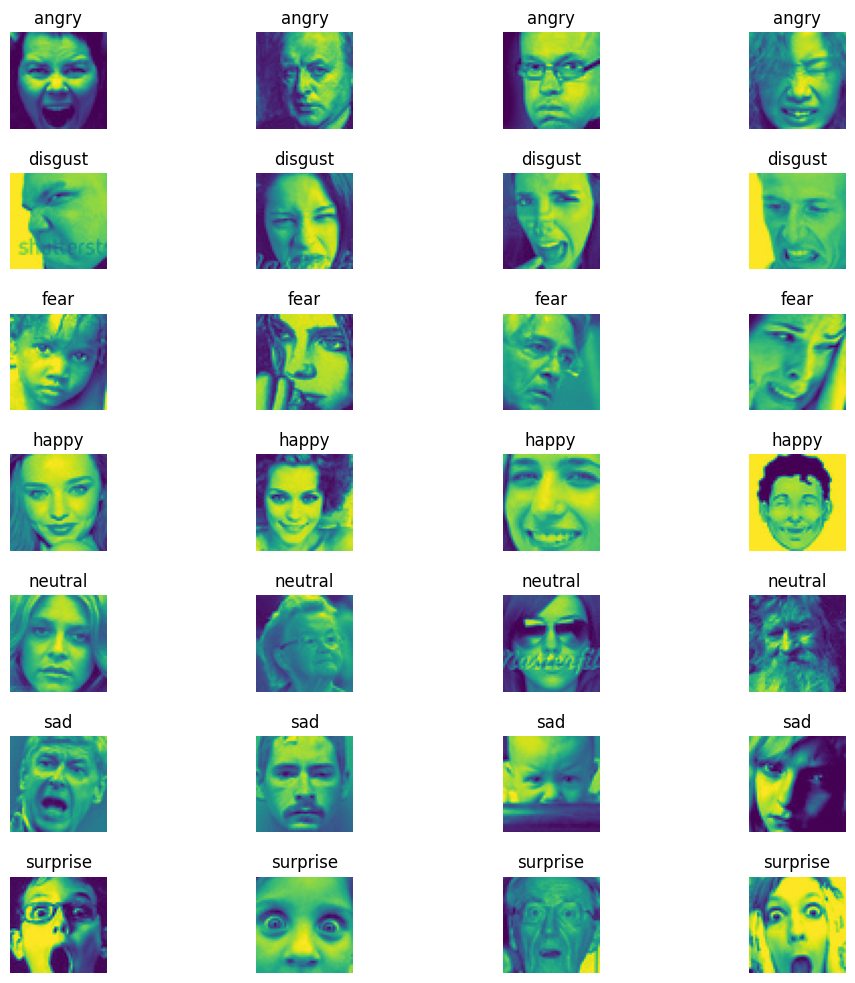

In [12]:
displayRandomImages(train_images)

In [13]:
# sleep 
import time
time.sleep(2)

In [14]:
from sklearn.utils import resample
from keras.preprocessing.image import ImageDataGenerator

# this function augments the data and balances the classes
# it uses the per_label_range_train variable which was calculated earlier
# ranges for minority and majority classes are calculated
# minority class is oversampled using the resample function
# augmented images are generated using the ImageDataGenerator
# augmented images are reshaped and added to the train_images list
# labels are also added to the train_labels list
# minority class images are deleted from the train_images list
def augmentDataAndBalance():
    global train_images, train_labels, labels, per_label_range_train
    for curLabel in labels:
        if curLabel == "happy":
            continue
        else:
            minority_class_images_start = 0
            minority_class_images_end = 0
            majority_class_images_start = 0
            majority_class_images_end = 0
            for i,rangeSet in enumerate(per_label_range_train):
                min,max,label,count = rangeSet
                if label == curLabel:
                    print(rangeSet)
                    minority_class_images_start = min
                    minority_class_images_end = max
                elif label == "happy":
                    majority_class_images_start = min
                    majority_class_images_end = max

            minority_class_images = train_images[minority_class_images_start:minority_class_images_end+1]
            majority_class_images = train_images[majority_class_images_start:majority_class_images_end+1]

            print("Number of majority class images: ",len(majority_class_images))
            print("Number of minority class images: ",len(minority_class_images))

            oversampled_minority_class_images = resample(minority_class_images,
                                                        replace=True,
                                                        n_samples=len(majority_class_images),
                                                        random_state=42)
            
            # Define an ImageDataGenerator for augmentation
            datagen = ImageDataGenerator(
                rotation_range=10,      
                width_shift_range=0.1,  
                height_shift_range=0.1, 
                zoom_range=0.1,         
                horizontal_flip=True,   
                fill_mode='nearest'     
            )

            augmented_minority_images = []

            for images in oversampled_minority_class_images:
                
                for batch in datagen.flow(np.reshape(images, (1, images.shape[0], images.shape[1], 1)), batch_size=1):
                    augmented_minority_images.extend(batch)
                    break
                
            # reshape the augmented images
            shuffled_indexes = np.arange(len(augmented_minority_images))
            np.random.shuffle(shuffled_indexes)
            augmented_minority_images = np.array(augmented_minority_images)[shuffled_indexes]
            augmented_minority_images = [np.reshape(image, (image.shape[0], image.shape[1])) for image in augmented_minority_images]
                
            train_images = train_images + augmented_minority_images
            train_labels = train_labels + [curLabel]*len(oversampled_minority_class_images)

            for i in range(minority_class_images_start,minority_class_images_end+1):
                del train_images[i]
                del train_labels[i]
    return

augmentDataAndBalance()
            

(17664, 21656, 'angry', 3993)
Number of majority class images:  7164
Number of minority class images:  3993
(4982, 5417, 'disgust', 436)
Number of majority class images:  7164
Number of minority class images:  436
(13561, 17663, 'fear', 4103)
Number of majority class images:  7164
Number of minority class images:  4103
(0, 4981, 'neutral', 4982)
Number of majority class images:  7164
Number of minority class images:  4982
(5418, 10355, 'sad', 4938)
Number of majority class images:  7164
Number of minority class images:  4938
(10356, 13560, 'surprise', 3205)
Number of majority class images:  7164
Number of minority class images:  3205


In [15]:
print("Number of train images",len(train_images))
print("Number of train labels",len(train_labels))

Number of train images 50148
Number of train labels 50148


# Perform Label Encoding

In [16]:
# label encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(len(train_labels_encoded))
print(len(train_labels))

test_labels_encoded = le.transform(test_labels)
print(len(test_labels_encoded))
print(len(test_labels_encoded))


50148
50148
7066
7066


# Constructing CNN

In [17]:
train_images = np.array(train_images)
train_labels_encoded = np.array(train_labels_encoded)
# reshape the images for the model to be 48x48x1
train_images = train_images.reshape(-1,48,48,1)

print(train_images.shape)
print(train_labels_encoded.shape)

(50148, 48, 48, 1)
(50148,)


In [18]:
# # define model
import sklearn
import gc
# def defineModel():
#     model = None
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
#     model.add(tf.keras.layers.MaxPool2D((2, 2)))
#     model.add(tf.keras.layers.Dropout(0.2))
#     model.add(tf.keras.layers.BatchNormalization())

#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(units=64,activation='relu'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dense(units=len(labels),activation='softmax'))
    
#     model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(optimizer=model.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#     print(model.summary())
#     return model
    
# define model
# def defineModel(layer1_units, dense_units, dropout_rate, learning_rate):
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Conv2D(layer1_units, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
#     model.add(tf.keras.layers.MaxPool2D((2, 2)))
#     model.add(tf.keras.layers.Dropout(dropout_rate))
#     model.add(tf.keras.layers.BatchNormalization())

#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(units=dense_units,activation='relu'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dense(units=len(labels),activation='softmax'))
    
#     model.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(optimizer=model.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#     print(model.summary())
#     return model

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_accuracy',patience=5,verbose=1,restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1,min_delta=0.0001)

callbacks_list=[early_stopping,reduce_learning_rate]
# This function is used to define the model
# it takes the dropout rate and learning rate as parameters
# it returns the model
# used in hyperparameter tuning
def defineModel(dropout_rate, learning_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), input_shape=(48,48,1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=32))
    model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(units=len(labels),activation='softmax'))
    
    model.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=model.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model


param_grid = {
    'dropout_rate': [0.2,0.3],
    'learning_rate': [0.001],
    'batch_size': [256,512],
    'epochs': [30]
}

# This function is used to perform hyperparameter tuning
# it takes the train, validation and test data as parameters
# it returns the best model, best parameters and the history of the best model
# best model is the model with the highest accuracy on test data
def hyperParameterTuning(train_images,train_labels_encoded,validation_images,validation_labels,test_images,test_labels_encoded,param_grid):
    bestModel = None
    bestParams = None
    bestHistory = None
    bestAccuracy = float('-inf')

    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    print("Dropout_rate: ",dropout_rate," learning_rate: ",learning_rate," batch_size: ",batch_size, "Epochs: ",epochs)
                    model = defineModel(dropout_rate,learning_rate)
                    with tf.device('/GPU:0'):
                        history = model.fit(train_images,train_labels_encoded,epochs=epochs,batch_size=batch_size,validation_data=(validation_images,validation_labels),verbose=1,callbacks=callbacks_list)
                        _,accuracy = model.evaluate(test_images,test_labels_encoded,verbose=0)
                    if accuracy > bestAccuracy:
                        bestAccuracy = accuracy
                        bestModel = model
                        bestParams = {'dropout_rate': dropout_rate, 'learning_rate': learning_rate, 'batch_size': batch_size, 'epochs': epochs}
                        bestHistory = history
                    gc.collect()
    return bestModel,bestParams,bestHistory    
    


# Shuffle Training Data

In [19]:
# shuffle data
from sklearn.utils import shuffle
# since data was augmented, shuffle again
train_images, train_labels_encoded = shuffle(train_images, train_labels_encoded, random_state=42)

In [20]:
test_images = np.array(test_images).reshape(-1,48,48,1)

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
# split train data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)

In [22]:
bestModel,bestParams,bestHistory = hyperParameterTuning(X_train,y_train,test_images,test_labels_encoded,X_test,y_test,param_grid)

Dropout_rate:  0.2  learning_rate:  0.001  batch_size:  256 Epochs:  30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                  

2023-10-22 17:53:52.530957: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 17:53:53.184692: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.


Epoch 1/30


2023-10-22 17:53:55.666197: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-22 17:53:58.302651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-22 17:54:02.510142: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdd68001760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 17:54:02.510198: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-10-22 17:54:02.517479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 17:54:02.642333: I ./tensorflow/compiler/jit/device_compil

157/157 [==============================] - 21s 61ms/step - loss: 1.7910 - accuracy: 0.3129 - val_loss: 1.9625 - val_accuracy: 0.2603 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 8s 51ms/step - loss: 1.5258 - accuracy: 0.4260 - val_loss: 1.6451 - val_accuracy: 0.3804 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 8s 51ms/step - loss: 1.4178 - accuracy: 0.4660 - val_loss: 1.7462 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 8s 51ms/step - loss: 1.3539 - accuracy: 0.4877 - val_loss: 1.8802 - val_accuracy: 0.3204 - lr: 0.0010
Epoch 5/30
156/157 [============================>.] - ETA: 0s - loss: 1.3034 - accuracy: 0.5123
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
157/157 [==============================] - 8s 51ms/step - loss: 1.3034 - accuracy: 0.5123 - val_loss: 1.9365 - val_accuracy: 0.3070 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 8s 51ms/step - 

2023-10-22 17:56:02.203426: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 17:56:02.640633: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.


Epoch 1/30


2023-10-22 17:56:03.706263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


79/79 [==============================] - 13s 104ms/step - loss: 1.8637 - accuracy: 0.2865 - val_loss: 2.3484 - val_accuracy: 0.1524 - lr: 0.0010
Epoch 2/30
79/79 [==============================] - 8s 96ms/step - loss: 1.6165 - accuracy: 0.3957 - val_loss: 2.2352 - val_accuracy: 0.1565 - lr: 0.0010
Epoch 3/30
79/79 [==============================] - 8s 95ms/step - loss: 1.4886 - accuracy: 0.4435 - val_loss: 1.6961 - val_accuracy: 0.3358 - lr: 0.0010
Epoch 4/30
79/79 [==============================] - 8s 96ms/step - loss: 1.4164 - accuracy: 0.4711 - val_loss: 1.9325 - val_accuracy: 0.2740 - lr: 0.0010
Epoch 5/30
79/79 [==============================] - 8s 95ms/step - loss: 1.3553 - accuracy: 0.4933 - val_loss: 1.9276 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 6/30
78/79 [============================>.] - ETA: 0s - loss: 1.3091 - accuracy: 0.5109
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
79/79 [==============================] - 8s 96ms/step - loss: 1.3091 

2023-10-22 17:58:48.680166: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 17:58:49.997198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - 10s 53ms/step - loss: 1.8303 - accuracy: 0.2904 - val_loss: 1.8227 - val_accuracy: 0.2669 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 8s 52ms/step - loss: 1.5838 - accuracy: 0.3994 - val_loss: 1.9858 - val_accuracy: 0.2593 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 8s 51ms/step - loss: 1.4596 - accuracy: 0.4512 - val_loss: 1.8676 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 4/30
156/157 [============================>.] - ETA: 0s - loss: 1.3977 - accuracy: 0.4731
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
157/157 [==============================] - 8s 51ms/step - loss: 1.3980 - accuracy: 0.4730 - val_loss: 1.8305 - val_accuracy: 0.3082 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 8s 51ms/step - loss: 1.3278 - accuracy: 0.5005 - val_loss: 1.6590 - val_accuracy: 0.3728 - lr: 5.0000e-04
Epoch 6/30
157/157 [==============================] - 8s 51ms/ste

2023-10-22 18:02:47.887642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


79/79 [==============================] - 9s 98ms/step - loss: 1.8728 - accuracy: 0.2740 - val_loss: 2.2730 - val_accuracy: 0.1988 - lr: 0.0010
Epoch 2/30
79/79 [==============================] - 8s 95ms/step - loss: 1.6536 - accuracy: 0.3716 - val_loss: 1.8609 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 3/30
79/79 [==============================] - 8s 95ms/step - loss: 1.5312 - accuracy: 0.4239 - val_loss: 1.8182 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 4/30
79/79 [==============================] - 8s 95ms/step - loss: 1.4568 - accuracy: 0.4544 - val_loss: 1.6422 - val_accuracy: 0.3753 - lr: 0.0010
Epoch 5/30
79/79 [==============================] - 8s 95ms/step - loss: 1.3892 - accuracy: 0.4799 - val_loss: 1.7959 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 6/30
79/79 [==============================] - 7s 95ms/step - loss: 1.3534 - accuracy: 0.4923 - val_loss: 1.9873 - val_accuracy: 0.2804 - lr: 0.0010
Epoch 7/30
78/79 [============================>.] - ETA: 0s - loss: 1.3191 - accuracy: 

In [23]:
print("Best params: ",bestParams)
print("Best accuracy: ",bestHistory.history['val_accuracy'][-1])

Best params:  {'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 30}
Best accuracy:  0.44225871562957764


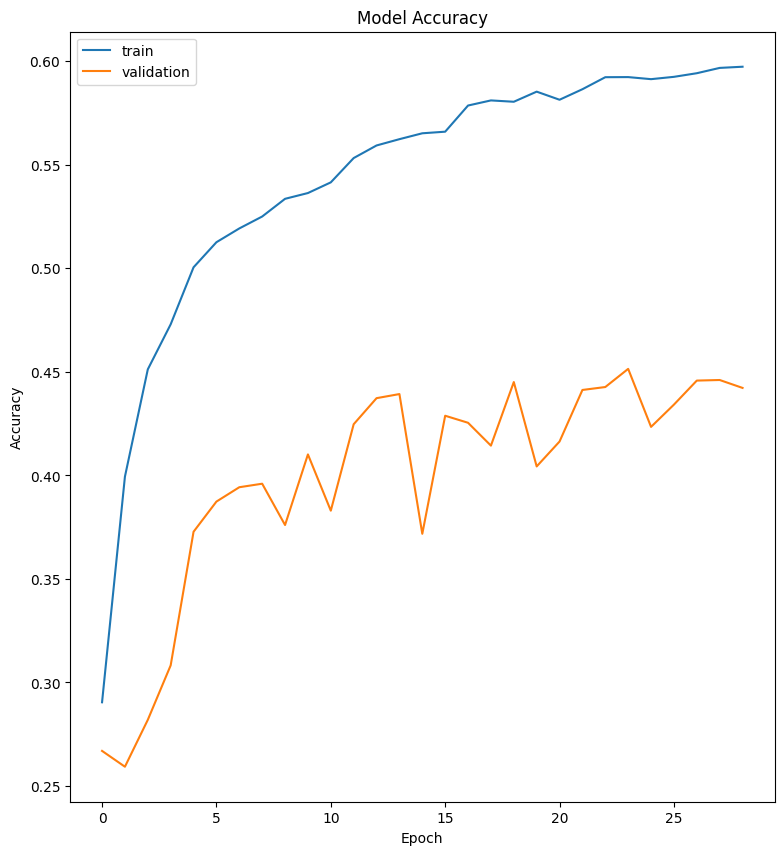

In [24]:
# plot accuracy and loss for train and validation data
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(bestHistory.history['accuracy'])
plt.plot(bestHistory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [25]:
# test_images = np.array(test_images).reshape(-1,48,48,1)

# evaluate the model on test data
loss,accuracy = bestModel.evaluate(X_test,y_test)
print(f"Accuracy: {accuracy*100} Loss: {loss}")

314/314 [==============================] - 2s 5ms/step - loss: 1.1921 - accuracy: 0.5462
Accuracy: 54.61615324020386 Loss: 1.19205904006958


In [26]:
# print evaliation metrics such as f1 score, accracy, precision and recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# print the classification report and confusion matrix
predictions = bestModel.predict(test_images)
predictions = np.argmax(predictions,axis=1)
print(classification_report(test_labels_encoded,predictions,labels=[0,1,2,3,4,5,6],target_names=labels))
print(confusion_matrix(test_labels_encoded,predictions))


221/221 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

       angry       0.52      0.18      0.27       960
     disgust       0.17      0.52      0.26       111
        fear       0.37      0.19      0.25      1018
       happy       0.80      0.60      0.69      1825
     neutral       0.39      0.68      0.49      1216
         sad       0.27      0.33      0.30      1139
    surprise       0.47      0.59      0.53       797

    accuracy                           0.45      7066
   macro avg       0.43      0.44      0.40      7066
weighted avg       0.50      0.45      0.45      7066

[[ 172   78   78   58  275  191  108]
 [   9   58    5    6   11   11   11]
 [  52   46  189   48  211  287  185]
 [  33   52   60 1094  314  183   89]
 [  10   25   34   76  824  170   77]
 [  52   62   96   51  440  381   57]
 [   3   11   45   32   54  180  472]]
